In [ ]:
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from scipy.stats import entropy
from pysteps.verification.probscores import CRPS
from pysteps.verification.salscores import sal
from pysteps.verification.spatialscores import fss
from pysteps.verification.rankhist import rankhist
import os
import glob

In [ ]:
#############################################################
##########  Observation vs Simulation COMPARISON  ###########
#############################################################

def read_raster(file_path, time_step):
    data = xr.open_dataset(file_path)
    raster = data["sequence"].isel(timestep=time_step)  

    if not raster.rio.crs:
        raster = raster.rio.write_crs("EPSG:32632")

    return raster

orario_specificato = "2023-09-15T00:45:00" # SELECTED FILE
durata_minuti = 100  
intervallo_minuti = 20  
num_membri = list(range(20))  

ldcast_dir = Path("../../ens/sept_ld_ens")
gptcast_dir = Path("../../ens/sept_gpt_ens")

file_list = sorted(ldcast_dir.glob("*.nc"))
file_specificato = None
for file in file_list:
    if orario_specificato in file.name:
        file_specificato = file
        break

if file_specificato is None:
    raise ValueError(f"No file for time: {orario_specificato}")

ds_specificato = xr.open_dataset(file_specificato)
raster_osservato = read_raster(file_specificato, time_step=3)

orario_iniziale = datetime.strptime(orario_specificato, "%Y-%m-%dT%H:%M:%S")
file_paths = []
for minuto in range(0, durata_minuti + 1, intervallo_minuti):
    orario_corrente = orario_iniziale + timedelta(minutes=minuto)
    file_name = f"{orario_corrente.strftime('%Y-%m-%dT%H:%M:%S')}_0_utm32n.nc"  # MEMBER 0
    file_paths.append(file_name)

fig, axes = plt.subplots(3, len(file_paths), figsize=(15, 9), constrained_layout=True)

for i, file_path in enumerate(file_paths):
    ld_file_path = ldcast_dir / file_path  
    if not ld_file_path.exists():
        raise ValueError(f"File non trovato: {ld_file_path}")
    raster = read_raster(ld_file_path, time_step=3)
    im = axes[0, i].imshow(raster, cmap="turbo", norm=LogNorm(vmin=1e-1, vmax=1e2), zorder=2)  
    axes[0, i].set_title(f"+{i * intervallo_minuti} min", fontsize=16) 
    axes[0, i].grid(True, color="gray", linestyle="--", linewidth=0.5)
    axes[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  

time_steps_ldcast = [7, 11, 15, 19, 23]
for i, time_step in enumerate(time_steps_ldcast):
    raster = read_raster(file_specificato, time_step=time_step)
    im = axes[1, i + len(file_paths) - len(time_steps_ldcast)].imshow(raster, cmap="turbo", norm=LogNorm(vmin=1e-1, vmax=1e2), zorder=2)
    axes[1, i + len(file_paths) - len(time_steps_ldcast)].grid(True, color="gray", linestyle="--", linewidth=0.5)
    axes[1, i + len(file_paths) - len(time_steps_ldcast)].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

time_steps_gptcast = [7, 11, 15, 19, 23]
for i, time_step in enumerate(time_steps_gptcast):
    gpt_file = gptcast_dir / file_specificato.name
    if not gpt_file.exists():
        raise ValueError(f"File GPTCast non trovato: {gpt_file}")
    raster = read_raster(gpt_file, time_step=time_step)
    im = axes[2, i + len(file_paths) - len(time_steps_gptcast)].imshow(raster, cmap="turbo", norm=LogNorm(vmin=1e-1, vmax=1e2), zorder=2)
    axes[2, i + len(file_paths) - len(time_steps_gptcast)].grid(True, color="gray", linestyle="--", linewidth=0.5)
    axes[2, i + len(file_paths) - len(time_steps_gptcast)].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
axes[1, 0].axis("off")  
axes[2, 0].axis("off") 

cbar = fig.colorbar(im, ax=axes[:, -1], orientation="vertical", fraction=0.10, pad=0.08)  
cbar.set_label("Intensity [mm h⁻¹]", fontsize=16)  
cbar.ax.tick_params(labelsize=14)  

axes[0, 0].set_ylabel("Observation", fontsize=20)
axes[1, len(file_paths) - len(time_steps_ldcast)].set_ylabel("LDCast", fontsize=20)
axes[2, len(file_paths) - len(time_steps_gptcast)].set_ylabel("GPTCast", fontsize=20)

plt.show()

In [ ]:
#############################################################
#################### CRPS COMPUTATION #######################
#############################################################

orario_iniziale = "2023-09-15T01:15:00" 
durata_minuti = 120  
durata_calcolo = 240 
intervallo_minuti = 5  
num_membri = list(range(20))  

ldcast_dir = Path("../../ens/sept_ld_ens")
gptcast_dir = Path("../../ens/sept_gpt_ens")

def find_file(directory, timestamp):
    file_list = sorted(directory.glob("*.nc"))
    for file in file_list:
        if timestamp in file.name:
            return file
    return None

def create_observed_vector(orario_iniziale, durata_calcolo, intervallo_minuti, directory):
    observed_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") + timedelta(minutes=minuto)
        file_corrente = find_file(directory, orario_corrente.strftime("%Y-%m-%dT%H:%M:%S"))
        if file_corrente is None:
            raise ValueError(f"No file for time: {orario_corrente}")
        ds_corrente = xr.open_dataset(file_corrente)
        raster_corrente = ds_corrente["sequence"].isel(timestep=3).values
        observed_vector.append(raster_corrente)
    return observed_vector

def create_lead_time_vector(orario_iniziale, durata_calcolo, intervallo_minuti, lead_time, directory, num_membri):
    lead_time_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") - timedelta(minutes=lead_time - minuto)
        timestep_corrente = 3 + (lead_time // intervallo_minuti)
        ensemble_stack = []
        for membro in num_membri:
            file_membro = directory / f"{orario_corrente.strftime('%Y-%m-%dT%H:%M:%S')}_{membro}_utm32n.nc"
            if not file_membro.exists():
                continue
            ds_membro = xr.open_dataset(file_membro)
            if timestep_corrente >= ds_membro["sequence"].shape[0]:
                continue
            raster_membro = ds_membro["sequence"].isel(timestep=timestep_corrente).values
            if raster_membro.ndim == 2:  
                ensemble_stack.append({
                    "membro": membro,
                    "timestep": timestep_corrente,
                    "data": raster_membro
                })
            else:
                print(f"Error: ensemble member not 2D. Shape: {raster_membro.shape}")
        lead_time_vector.append({
            "timestamp": orario_corrente,
            "ensemble": ensemble_stack
        })
    return lead_time_vector

def calculate_crps(observed_vector, lead_time_vector):
    crps_results = []
    for i, raster_osservato in enumerate(observed_vector):
        ensemble_stack = []
        for ensemble_entry in lead_time_vector[i]["ensemble"]:
            raster_membro = ensemble_entry["data"]
            if raster_osservato.shape != raster_membro.shape:
                raise ValueError(
                    f"Observed dimension {raster_osservato.shape} "
                    f"does not correspond to simulated dimension {raster_membro.shape}."
                )
            ensemble_stack.append(raster_membro)
        
        if len(ensemble_stack) > 0:
            ensemble_stack = np.stack(ensemble_stack, axis=0)
            crps_value = CRPS(ensemble_stack, raster_osservato)
            crps_results.append(crps_value)
    return crps_results

results_crps = {"LDCast": {}, "GPTCast": {}}

for model_name in results_crps.keys():
    results_crps[model_name][0] = 0  

for model_name, model_dir in [("LDCast", ldcast_dir), ("GPTCast", gptcast_dir)]:
    observed_vector = create_observed_vector(orario_iniziale, durata_minuti, intervallo_minuti, model_dir)
    for lead_time in tqdm(range(5, durata_minuti + 1, intervallo_minuti), desc=f"Lead time {model_name}"):
        lead_time_vector = create_lead_time_vector(orario_iniziale, durata_minuti, intervallo_minuti, lead_time, model_dir, num_membri)
        crps_results = calculate_crps(observed_vector, lead_time_vector)
        results_crps[model_name][lead_time] = crps_results

print("CRPS computation completed for both models.")

In [ ]:
#############################################################
######################## CRPS PLOT ##########################
#############################################################

for model_name in results_crps.keys():
    results_crps[model_name][0] = [0]  

def plot_crps_with_dispersion(results_crps):
    
    plt.figure(figsize=(10, 6))

    for model_name, color in zip(results_crps.keys(), ["blue", "orange"]):
        crps_results = results_crps[model_name]  
        lead_times = sorted(crps_results.keys())  
        mean_crps = []  
        std_crps = []  
        for lead_time in lead_times:
            crps_values = crps_results[lead_time]  
            mean_crps.append(np.mean(crps_values))  
            std_crps.append(np.std(crps_values))  

            plt.scatter([lead_time] * len(crps_values), crps_values, color=color, alpha=0.5, label=f"Values {model_name}" if lead_time == lead_times[0] else "")

        plt.plot(lead_times, mean_crps, color=color, linewidth=2, label=f"Mean {model_name}")

        plt.fill_between(
            lead_times,
            np.array(mean_crps) - np.array(std_crps),
            np.array(mean_crps) + np.array(std_crps),
            color=color,
            alpha=0.2,
            label=f"{model_name} (± std)" if lead_time == lead_times[0] else ""
        )

    plt.title("CRPS evolution with Lead Time, September Case", fontsize=18)
    plt.xlabel("Lead Time [min]", fontsize=16)
    plt.ylabel("CRPS [mm h⁻¹]", fontsize=16)
    plt.grid()
    plt.legend(fontsize=14)
    plt.tick_params(axis="both", labelsize=15)  

    plt.tight_layout()

    plt.show()

plot_crps_with_dispersion(results_crps)

In [ ]:
#############################################################
##################### SAL COMPUTATION #######################
#############################################################

orario_iniziale = "2023-09-15T01:15:00"  
durata_minuti = 120  
durata_calcolo = 240 
intervallo_minuti = 5  
num_membri = list(range(20))  

ldcast_dir = Path("../../ens/sept_ld_ens")
gptcast_dir = Path("../../ens/sept_gpt_ens")

def find_file(directory, timestamp):
    file_list = sorted(directory.glob("*.nc"))
    for file in file_list:
        if timestamp in file.name:
            return file
    return None

def create_observed_vector(orario_iniziale, durata_calcolo, intervallo_minuti, directory):
    observed_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") + timedelta(minutes=minuto)
        file_corrente = find_file(directory, orario_corrente.strftime("%Y-%m-%dT%H:%M:%S"))
        if file_corrente is None:
            raise ValueError(f"No file for time: {orario_corrente}")
        ds_corrente = xr.open_dataset(file_corrente)
        raster_corrente = ds_corrente["sequence"].isel(timestep=3).values
        observed_vector.append(raster_corrente)
    return observed_vector

def create_lead_time_vector(orario_iniziale, durata_calcolo, intervallo_minuti, lead_time, directory, num_membri):
    lead_time_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") - timedelta(minutes=lead_time - minuto)
        timestep_corrente = 3 + (lead_time // intervallo_minuti)
        ensemble_stack = []
        for membro in num_membri:
            file_membro = directory / f"{orario_corrente.strftime('%Y-%m-%dT%H:%M:%S')}_{membro}_utm32n.nc"
            if not file_membro.exists():
                continue
            ds_membro = xr.open_dataset(file_membro)
            if timestep_corrente >= ds_membro["sequence"].shape[0]:
                continue
            raster_membro = ds_membro["sequence"].isel(timestep=timestep_corrente).values
            if raster_membro.ndim == 2:  
                ensemble_stack.append({
                    "membro": membro,
                    "timestep": timestep_corrente,
                    "data": raster_membro
                })
            else:
                print(f"Error: ensemble member not 2D. Shape: {raster_membro.shape}")
        lead_time_vector.append({
            "timestamp": orario_corrente,
            "ensemble": ensemble_stack
        })
    return lead_time_vector

def calculate_sal(observed_vector, lead_time_vector):
    sal_results = {"S": [], "A": [], "L": []}  
    for i, raster_osservato in enumerate(observed_vector):
        S_lead_time = []
        A_lead_time = []
        L_lead_time = []
        for ensemble_entry in lead_time_vector[i]["ensemble"]:
            raster_membro = ensemble_entry["data"]
            if raster_osservato.shape != raster_membro.shape:
                raise ValueError(
                    f"Observed dimension {raster_osservato.shape} "
                    f"does not correspond to simulated dimension {raster_membro.shape}."
                )
            S, A, L = sal(raster_osservato, raster_membro)
            S_lead_time.append(S)
            A_lead_time.append(A)
            L_lead_time.append(L)
        if S_lead_time and A_lead_time and L_lead_time:
            sal_results["S"].append(np.mean(S_lead_time))
            sal_results["A"].append(np.mean(A_lead_time))
            sal_results["L"].append(np.mean(L_lead_time))
    return sal_results

results_sal = {"LDCast": {}, "GPTCast": {}}

for model_name in results_sal.keys():
    results_sal[model_name][0] = {"S": 0, "A": 0, "L": 0}  

results_sal = {"LDCast": {}, "GPTCast": {}}
for model_name, model_dir in [("LDCast", ldcast_dir), ("GPTCast", gptcast_dir)]:
    observed_vector = create_observed_vector(orario_iniziale, durata_minuti, intervallo_minuti, model_dir)
    for lead_time in tqdm(range(5, durata_minuti + 1, intervallo_minuti), desc=f"Lead time {model_name}"):
        lead_time_vector = create_lead_time_vector(orario_iniziale, durata_minuti, intervallo_minuti, lead_time, model_dir, num_membri)
        sal_results = calculate_sal(observed_vector, lead_time_vector)
        results_sal[model_name][lead_time] = sal_results

print("SAL computation completed for both models.")

In [ ]:
#############################################################
######################### SAL PLOT ##########################
#############################################################

for model_name in results_sal.keys():
    if 0 not in results_sal[model_name]:
        results_sal[model_name][0] = {"S": [0], "A": [0], "L": [0]}  

def plot_sal_components(results_sal, durata_minuti, intervallo_minuti):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    components = ["S", "A", "L"]
    titles = ["Structure [S]", "Amplitude [A]", "Location [L]"]
    colors = {"LDCast": "blue", "GPTCast": "orange"}
    
    for i, component in enumerate(components):
        ax = axes[i]
        for model_name, model_results in results_sal.items():
            lead_times = sorted(model_results.keys())
            mean_values = []
            std_values = []
            
            for lead_time in lead_times:
                values = model_results[lead_time][component]
                mean_values.append(np.mean(values))
                std_values.append(np.std(values))
                
                ax.scatter([lead_time] * len(values), values, color=colors[model_name], alpha=0.5, label=f"Values {model_name}" if lead_time == intervallo_minuti else "")
            
            ax.plot(lead_times, mean_values, color=colors[model_name], label=f"Mean {model_name}")
            
            ax.fill_between(lead_times, 
                            np.array(mean_values) - np.array(std_values), 
                            np.array(mean_values) + np.array(std_values), 
                            color=colors[model_name], alpha=0.3)
        
        ax.set_title(f"{titles[i]}, September Case", fontsize=14)
        
        ax.set_ylabel(f"{component} [-]", fontsize=16)
        
        if component in ["S", "A"]:
            ax.set_ylim(-2, 2)  
        elif component == "L":
            ax.set_ylim(0, 2)  
        
        ax.tick_params(axis="both", labelsize=14)
        
        if component == "A":
            ax.legend(loc="lower left", fontsize=14)  
        else:
            ax.legend(loc="upper left", fontsize=14)  
        ax.grid(True)
    
    axes[-1].set_xlabel("Lead Time [min]", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  

    plt.show()

plot_sal_components(results_sal, durata_minuti, intervallo_minuti)

In [ ]:
#############################################################
#################### FSS COMPUTATION ########################
#############################################################

orario_iniziale = "2023-09-15T01:15:00"  
durata_minuti = 120  
durata_calcolo = 240  
intervallo_minuti = 5  
num_membri = list(range(20))  

finestre_spaziali = [1, 8, 14, 64, 128, 267]  # SPATIAL WINDOW
soglie = [0.1, 2.5, 10]  # THRESHOLDS

ldcast_dir = Path("../../ens/sept_ld_ens")
gptcast_dir = Path("../../ens/sept_gpt_ens")

def find_file(directory, timestamp):
    file_list = sorted(directory.glob("*.nc"))
    for file in file_list:
        if timestamp in file.name:
            return file
    return None

def create_observed_vector(orario_iniziale, durata_calcolo, intervallo_minuti, directory, num_membri):
    observed_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") + timedelta(minutes=minuto)
        file_corrente = find_file(directory, orario_corrente.strftime("%Y-%m-%dT%H:%M:%S"))
        if file_corrente is None:
            raise ValueError(f"No files for time: {orario_corrente}")
        ds_corrente = xr.open_dataset(file_corrente)
        raster_corrente = ds_corrente["sequence"].isel(timestep=3).values
        observed_vector.append(raster_corrente)
    return observed_vector

def create_lead_time_vector(orario_iniziale, durata_calcolo, intervallo_minuti, lead_time, directory, num_membri):
    lead_time_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") - timedelta(minutes=lead_time - minuto)
        timestep_corrente = 3 + (lead_time // intervallo_minuti)
        ensemble_stack = []
        for membro in num_membri:
            file_membro = directory / f"{orario_corrente.strftime('%Y-%m-%dT%H:%M:%S')}_{membro}_utm32n.nc"
            if not file_membro.exists():
                continue
            ds_membro = xr.open_dataset(file_membro)
            if timestep_corrente >= ds_membro["sequence"].shape[0]:
                continue
            # Seleziona i dati per il timestep corrente
            raster_membro = ds_membro["sequence"].isel(timestep=timestep_corrente).values
            if raster_membro.ndim == 2:  # Verifica che sia 2D
                # Aggiungi informazioni sul membro e sul passo temporale
                ensemble_stack.append({
                    "membro": membro,
                    "timestep": timestep_corrente,
                    "data": raster_membro
                })
            else:
                print(f"Error: ensemble member not 2D. Shape: {raster_membro.shape}")
        lead_time_vector.append({
            "timestamp": orario_corrente,
            "ensemble": ensemble_stack
        })
    return lead_time_vector

def calculate_fss(observed_vector, lead_time_vector, finestre_spaziali, soglie):
    fss_results = {window: {threshold: [] for threshold in soglie} for window in finestre_spaziali}
    for i, raster_osservato in enumerate(observed_vector):
        if "ensemble" not in lead_time_vector[i] or not lead_time_vector[i]["ensemble"]:
            print(f"Attenzione: Nessun ensemble trovato per lead_time_vector[{i}]")
            continue
        
        for window in finestre_spaziali:
            for threshold in soglie:
                fss_lead_time = []
                for ensemble_entry in lead_time_vector[i]["ensemble"]:
                    raster_membro = ensemble_entry["data"]
                    if raster_osservato.shape != raster_membro.shape:
                        raise ValueError(
                            f"Observed dimension {raster_osservato.shape} "
                            f"does not correspond to simulated dimension {raster_membro.shape}."
                        )
                    fss_value = fss(raster_osservato, raster_membro, threshold, window)
                    fss_lead_time.append(fss_value)
                if fss_lead_time:
                    fss_results[window][threshold].append(np.mean(fss_lead_time))
    return fss_results

results_fss = {"LDCast": {}, "GPTCast": {}}

for model_name in results_fss.keys():
    results_fss[model_name][0] = {window: {threshold: 1 for threshold in soglie} for window in finestre_spaziali}

for model_name, model_dir in [("LDCast", ldcast_dir), ("GPTCast", gptcast_dir)]:
    print(f"Calcolo FSS per il modello: {model_name}")
    observed_vector = create_observed_vector(orario_iniziale, durata_minuti, intervallo_minuti, model_dir, num_membri)
    
    # Aggiungi tqdm per monitorare i progressi sui lead time
    for lead_time in tqdm(range(5, durata_minuti + 1, intervallo_minuti), desc=f"Lead time {model_name}"):
        lead_time_vector = create_lead_time_vector(orario_iniziale, durata_minuti, intervallo_minuti, lead_time, model_dir, num_membri)
        fss_results = calculate_fss(observed_vector, lead_time_vector, finestre_spaziali, soglie)
        results_fss[model_name][lead_time] = fss_results

# Risultati finali
print("FSS computation completed for both models.")

In [ ]:
#############################################################
######################## FSS PLOT ###########################
#############################################################

def plot_fss(results_fss, soglia, finestra):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {"LDCast": "blue", "GPTCast": "orange"}
    
    for model_name, model_results in results_fss.items():
        lead_times = sorted(model_results.keys())
        mean_values = []
        std_values = []
        
        for lead_time in lead_times:
            fss_values = model_results[lead_time][finestra][soglia]
            
            if isinstance(fss_values, (int, float, np.float64)):
                fss_values = [fss_values]
            
            mean_values.append(np.mean(fss_values))
            std_values.append(np.std(fss_values))
            
            ax.scatter([lead_time] * len(fss_values), fss_values, color=colors[model_name], alpha=0.5, label=f"Values {model_name}" if lead_time == 0 else "")
        
        ax.plot(lead_times, mean_values, color=colors[model_name], label=f"Mean {model_name}")
        
        ax.fill_between(lead_times, 
                        np.array(mean_values) - np.array(std_values), 
                        np.array(mean_values) + np.array(std_values), 
                        color=colors[model_name], alpha=0.3)
    
    ax.set_title(f"FSS vs Lead Time, September Case (Threshold: {soglia} mm h⁻¹, Window: {finestra} km x {finestra} km)", fontsize=18)
    ax.set_xlabel("Lead Time [min]", fontsize=16)
    ax.set_ylabel("FSS [-]", fontsize=16)
    ax.legend(loc="upper right", fontsize=16)
    plt.tick_params(axis="both", labelsize=15)
    ax.grid(True)
    plt.tight_layout()

    plt.show()

plot_fss(results_fss, soglia=2.5, finestra=14)

In [ ]:
#############################################################
#################### FSS vs THRESHOLD #######################
#############################################################

def plot_fss_lines(results_fss, finestra, soglie):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {"LDCast": "blue", "GPTCast": "orange"}
    line_styles = {0.1: "-", 2.5: "--", 10: ":"}  
    
    for model_name, model_results in results_fss.items():
        lead_times = sorted(model_results.keys())
        
        for threshold in soglie:
            mean_values = []
            
            for lead_time in lead_times:
                fss_values = model_results[lead_time][finestra][threshold]
                mean_values.append(np.mean(fss_values))
            
            ax.plot(lead_times, mean_values, color=colors[model_name], linestyle=line_styles[threshold], marker="o",
                    label=f"{model_name} (T = {threshold} mm h⁻¹)")
    
    ax.set_title(f"FSS vs Lead Time, September Case (Window: {finestra} km x {finestra} km)", fontsize=18)
    ax.set_xlabel("Lead Time [min]", fontsize=16)
    ax.set_ylabel("FSS [-]", fontsize=16)
    ax.legend(loc="upper right", fontsize=14)
    plt.tick_params(axis="both", labelsize=15)
    ax.grid(True)
    plt.tight_layout()

    plt.show()

plot_fss_lines(results_fss, finestra=14, soglie=[0.1, 2.5, 10])

In [ ]:
#############################################################
################### FSS vs SPATIAL (LD) #####################
#############################################################

def plot_fss_spatial_window(results_fss, model_name, threshold, lead_times, seveso_window, y_limits=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {20: "blue", 40: "orange", 60: "green", 80: "red", 100: "purple"}  
    line_styles = {20: "-", 40: "-", 60: "-", 80: "-", 100: "-"}  
    
    model_results = results_fss[model_name]
    spatial_windows = sorted(model_results[20].keys())  
   
    spatial_windows = [w for w in spatial_windows if w != 8]
    
    for lead_time in lead_times:
        mean_values = []
        
        for window in spatial_windows:
            fss_values = model_results[lead_time][window][threshold]
            mean_values.append(np.mean(fss_values))
        
        ax.plot(spatial_windows, mean_values, color=colors[lead_time], linestyle=line_styles[lead_time],
                marker="o", label=f"Lead Time: {lead_time} min")
    
    ax.axvline(x=seveso_window, color="red", linestyle="--", label="Seveso Basin")
    
    ax.set_title(f"FSS vs Spatial Window, September Case, {model_name} (Threshold: {threshold}  mm h⁻¹)", fontsize=18)
    ax.set_xlabel("Spatial Window [km x km]", fontsize=16)
    ax.set_ylabel("FSS [-]", fontsize=16)
    ax.set_xticks(spatial_windows)
    ax.set_xticklabels([f"{w}x{w}" for w in spatial_windows], rotation=90, ha="right") 
    ax.legend(loc="lower right", fontsize=15)
    plt.tick_params(axis="both", labelsize=15)

    if y_limits:
        ax.set_ylim(y_limits)
        
    ax.grid(True)
    plt.tight_layout()

    plt.show()

plot_fss_spatial_window(results_fss, model_name="LDCast", threshold=0.1, lead_times=[20, 40, 60, 80, 100], seveso_window=14, y_limits=(0, 1))
plot_fss_spatial_window(results_fss, model_name="LDCast", threshold=2.5, lead_times=[20, 40, 60, 80, 100], seveso_window=14, y_limits=(0, 1))
plot_fss_spatial_window(results_fss, model_name="LDCast", threshold=10, lead_times=[20, 40, 60, 80, 100], seveso_window=14, y_limits=(0, 1))

In [ ]:
#############################################################
################### FSS vs SPATIAL (GPT) ####################
#############################################################

def plot_fss_spatial_window(results_fss, model_name, threshold, lead_times, seveso_window, y_limits=None):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = {20: "blue", 40: "orange", 60: "green", 80: "red", 100: "purple"}  
    line_styles = {20: "-", 40: "-", 60: "-", 80: "-", 100: "-"}  
    
    model_results = results_fss[model_name]
    spatial_windows = sorted(model_results[20].keys())  

    spatial_windows = [w for w in spatial_windows if w != 8]
    
    for lead_time in lead_times:
        mean_values = []
        
        for window in spatial_windows:
            fss_values = model_results[lead_time][window][threshold]
            mean_values.append(np.mean(fss_values))
        
        ax.plot(spatial_windows, mean_values, color=colors[lead_time], linestyle=line_styles[lead_time],
                marker="o", label=f"Lead Time: {lead_time} min")
    
    ax.axvline(x=seveso_window, color="red", linestyle="--", label="Seveso Basin")
    
    ax.set_title(f"FSS vs Spatial Window, September Case, {model_name} (Threshold: {threshold}  mm h⁻¹)", fontsize=18)
    ax.set_xlabel("Spatial Window [km x km]", fontsize=16)
    ax.set_ylabel("FSS [-]", fontsize=16)
    ax.set_xticks(spatial_windows)
    ax.set_xticklabels([f"{w}x{w}" for w in spatial_windows], rotation=90, ha="right") 
    ax.legend(loc="lower right", fontsize=15)
    plt.tick_params(axis="both", labelsize=15)

    if y_limits:
        ax.set_ylim(y_limits)
        
    ax.grid(True)
    plt.tight_layout()

    plt.show()

plot_fss_spatial_window(results_fss, model_name="GPTCast", threshold=0.1, lead_times=[20, 40, 60, 80, 100], seveso_window=14, y_limits=(0, 1))
plot_fss_spatial_window(results_fss, model_name="GPTCast", threshold=2.5, lead_times=[20, 40, 60, 80, 100], seveso_window=14, y_limits=(0, 1))
plot_fss_spatial_window(results_fss, model_name="GPTCast", threshold=10, lead_times=[20, 40, 60, 80, 100], seveso_window=14, y_limits=(0, 1))

In [ ]:
#############################################################
################### RANK H COMPUTATION ######################
#############################################################

orario_iniziale = "2023-09-15T01:15:00"  
durata_minuti = 120  
durata_calcolo = 240  
intervallo_minuti = 5  
num_membri = list(range(20)) 

ldcast_dir = Path("../../ens/sept_ld_ens")
gptcast_dir = Path("../../ens/sept_gpt_ens")

def find_file(directory, timestamp):
    file_list = sorted(directory.glob("*.nc"))
    for file in file_list:
        if timestamp in file.name:
            return file
    return None

def create_observed_vector(orario_iniziale, durata_calcolo, intervallo_minuti, directory, num_membri):
    observed_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") + timedelta(minutes=minuto)
        file_corrente = find_file(directory, orario_corrente.strftime("%Y-%m-%dT%H:%M:%S"))
        if file_corrente is None:
            raise ValueError(f"No file for time: {orario_corrente}")
        ds_corrente = xr.open_dataset(file_corrente)
        raster_corrente = ds_corrente["sequence"].isel(timestep=3).values
        observed_vector.append(raster_corrente)
    return observed_vector

def create_lead_time_vector(orario_iniziale, durata_calcolo, intervallo_minuti, lead_time, directory, num_membri):
    lead_time_vector = []
    for minuto in range(0, durata_calcolo + 1, intervallo_minuti):
        orario_corrente = datetime.strptime(orario_iniziale, "%Y-%m-%dT%H:%M:%S") - timedelta(minutes=lead_time - minuto)
        timestep_corrente = 3 + (lead_time // intervallo_minuti)
        ensemble_stack = []
        for membro in num_membri:
            file_membro = directory / f"{orario_corrente.strftime('%Y-%m-%dT%H:%M:%S')}_{membro}_utm32n.nc"
            if not file_membro.exists():
                continue
            ds_membro = xr.open_dataset(file_membro)
            if timestep_corrente >= ds_membro["sequence"].shape[0]:
                continue
            raster_membro = ds_membro["sequence"].isel(timestep=timestep_corrente).values
            if raster_membro.ndim == 2:  
                ensemble_stack.append({
                    "membro": membro,
                    "timestep": timestep_corrente,
                    "data": raster_membro
                })
            else:
                print(f"Error: ensemble member not 2D. Shape: {raster_membro.shape}")
        lead_time_vector.append({
            "timestamp": orario_corrente,
            "ensemble": ensemble_stack
        })
    return lead_time_vector

def calculate_rank_histogram(observed_vector, lead_time_vector):
    
    rank_histogram = None  
    for i, raster_osservato in enumerate(observed_vector):
        ensemble_stack = []
        for ensemble_entry in lead_time_vector[i]["ensemble"]:
            raster_membro = ensemble_entry["data"]
            if raster_osservato.shape != raster_membro.shape:
                raise ValueError(
                    f"Observed dimension {raster_osservato.shape} "
                    f"does not correspond to simulated dimension {raster_membro.shape}."
                )
            ensemble_stack.append(raster_membro)
        
        if len(ensemble_stack) > 0:
            ensemble_stack = np.stack(ensemble_stack, axis=0)
            current_rank_histogram = rankhist(ensemble_stack, raster_osservato)
            
            if rank_histogram is None:
                rank_histogram = np.zeros_like(current_rank_histogram, dtype=float)
            
            rank_histogram += current_rank_histogram.astype(float)  
    
    return rank_histogram

results_rank_histogram = {"LDCast": {}, "GPTCast": {}}

for model_name in results_rank_histogram.keys():
    results_rank_histogram[model_name][0] = np.zeros(21, dtype=int)  

for model_name, model_dir in [("LDCast", ldcast_dir), ("GPTCast", gptcast_dir)]:
    observed_vector = create_observed_vector(orario_iniziale, durata_minuti, intervallo_minuti, model_dir, num_membri)
    for lead_time in tqdm(range(5, durata_minuti + 1, intervallo_minuti), desc=f"Lead time {model_name}"):
        lead_time_vector = create_lead_time_vector(orario_iniziale, durata_minuti, intervallo_minuti, lead_time, model_dir, num_membri)
        rank_histogram = calculate_rank_histogram(observed_vector, lead_time_vector)
        results_rank_histogram[model_name][lead_time] = rank_histogram

print("Rank Histogram computation completed for both models.")

In [ ]:
#############################################################
###################### RANK H PLOT ##########################
#############################################################

def plot_rank_histogram(results_rank_histogram, num_membri, model_name, lead_times_to_plot):
    
    plt.figure(figsize=(12, 6))
    ideal_value = 1 / (num_membri + 1)  
    x_ticks = np.arange(1, num_membri + 2)  

    for lead_time in lead_times_to_plot:
        if lead_time in results_rank_histogram[model_name]:  
            histogram = results_rank_histogram[model_name][lead_time]
            
            relative_frequency = histogram / np.sum(histogram)
            
            uniform_distribution = np.full_like(relative_frequency, ideal_value)
            kl_divergence = entropy(relative_frequency, uniform_distribution)
            
            plt.plot(x_ticks, relative_frequency, label=f"{lead_time}min: KL = {kl_divergence:.3f}")

    plt.axhline(ideal_value, color="black", linestyle="--", linewidth=1.5, label="Ideal Value")

    plt.title(f"Rank Distribution for {model_name}, September Case", fontsize=18)
    plt.xlabel("Rank of observation", fontsize=16)
    plt.ylabel("Relative Frequency [-]", fontsize=16)
    plt.ylim(0.03, 0.07)  
    plt.grid()

    plt.xticks(ticks=x_ticks, fontsize=16)

    plt.tick_params(axis="y", labelsize=16)

    plt.legend(fontsize=14)
    plt.tight_layout()

    plt.show()

lead_times_to_plot = [20, 40, 60, 80, 100]

plot_rank_histogram(results_rank_histogram, len(num_membri), "LDCast", lead_times_to_plot)
plot_rank_histogram(results_rank_histogram, len(num_membri), "GPTCast", lead_times_to_plot)

In [ ]:
#############################################################
################# CUM PREC COMPUTATION ######################
#############################################################

timestamp_iniziale = "2023-09-15T01:15:00"
time_interval = 5  
ensemble_members = range(20)  


ldcast_dir = Path("../../ens/sept_ld_mean")
gptcast_dir = Path("../../ens/sept_gpt_mean")

shapefile_path = "../../data/nodo_idraulico_shape/Bacini_OUT.shp"
bacini = gpd.read_file(shapefile_path)
bacini = bacini[bacini["Nome_bacin"].isin(["SEVESO alto", "SEVESO medio", "SEVESO basso"])]
bacini = bacini.to_crs("EPSG:32632")
bacini_uniti = bacini.unary_union

lead_times = list(range(5, 65, 5))

def carica_dati_con_crs(file_path, crs="EPSG:32632"):
    ds = xr.open_dataset(file_path)
    if not ds.rio.crs:
        ds = ds.rio.write_crs(crs) 
    return ds

def elabora_dati_osservati(directory, bacino, lead_times, time_interval):
    observed_files = []
    
    start_time = datetime.strptime(timestamp_iniziale, "%Y-%m-%dT%H:%M:%S")
    for i in range(120):  
        current_time = start_time + timedelta(minutes=i * time_interval)
        timestamp = current_time.strftime("%Y-%m-%dT%H:%M:%S")
        pattern = os.path.join(directory, f"{timestamp}_ensemble_mean_utm32n.nc")
        files = glob.glob(pattern)
        if files:
            observed_files.append(files[0])  
        else:
            print(f"No file for: {pattern}")

    observed_data = []
    for file in observed_files:
        ds = carica_dati_con_crs(file)
        
        if 3 < len(ds["sequence"]):
            observed_data.append(ds["sequence"].isel(timestep=3))  
        else:
            print(f"Timestep 3 not available in {file}")

    if observed_data:
        cumulative_rainfall = calcola_pioggia_cumulata(observed_data, bacino, time_interval)
        cumulative_rainfall = [0.0] + list(cumulative_rainfall)  
        return cumulative_rainfall
    else:
        raise ValueError("No data.")

def elabora_dati_simulati(directory, bacino, lead_times, time_interval):
    cumulative_rainfall = []
    
    for lead_time in lead_times:
        start_time = datetime.strptime(timestamp_iniziale, "%Y-%m-%dT%H:%M:%S") - timedelta(minutes=lead_time)
        
        files = []
        for i in range(120):  
            current_time = start_time + timedelta(minutes=i * time_interval)
            timestamp = current_time.strftime("%Y-%m-%dT%H:%M:%S")
            pattern = os.path.join(directory, f"{timestamp}_ensemble_mean_utm32n.nc")
            matched_files = glob.glob(pattern)
            if matched_files:
                files.append(matched_files[0])  
            else:
                print(f"File not found in: {pattern}")
        
        simulated_data = []
        timestep_offset = 3 + lead_time // time_interval 
        for file in files:
            simulated_ds = carica_dati_con_crs(file)
            
            if timestep_offset < len(simulated_ds["sequence"]):
                data = simulated_ds["sequence"].isel(timestep=timestep_offset)
                simulated_data.append(data)
            else:
                print(f"Timestep {timestep_offset} not available in {file}")
        
        if simulated_data:
            cumulative_rainfall_lead_time = calcola_pioggia_cumulata(simulated_data, bacino, time_interval)
            cumulative_rainfall_lead_time = [0.0] + list(cumulative_rainfall_lead_time)  
            cumulative_rainfall.append(cumulative_rainfall_lead_time)
    
    return cumulative_rainfall

def calcola_pioggia_cumulata(data, area, time_interval):
    cumulative_rainfall = []
    for timestep in data:
        masked_data = ritaglia_dati(timestep, area)
        mean_rainfall = masked_data.mean().item()  
        rainfall_mm = mean_rainfall * (time_interval / 60)  
        cumulative_rainfall.append(rainfall_mm)
    return np.cumsum(cumulative_rainfall)  

def ritaglia_dati(data, area):
    mask = data.rio.clip([area], crs="EPSG:32632", drop=True)
    return mask

print("Observed data elaboration...")
observed_rainfall = elabora_dati_osservati(ldcast_dir, bacini_uniti, lead_times, time_interval)

print("LDCast - simulated data elaboration...")
ldcast_cumulative_rainfall = elabora_dati_simulati(ldcast_dir, bacini_uniti, lead_times, time_interval)

print("GPTCast - simulated data elaboration...")
gptcast_cumulative_rainfall = elabora_dati_simulati(gptcast_dir, bacini_uniti, lead_times, time_interval)

print("Elaboration completed.")

In [ ]:
#############################################################
###################### CUM PREC PLOT ########################
#############################################################

def plot_cumulative_rainfall_dual(observed_rainfall, ldcast_rainfall, gptcast_rainfall, lead_times, timestamp_iniziale, time_interval):
    excel_file = "sept_cum.xlsx"
    df = pd.read_excel(excel_file)

    if not pd.api.types.is_string_dtype(df['Cumulata']):
        df['Cumulata'] = df['Cumulata'].astype(str)
    
    df['Rainfall'] = df['Cumulata'].str.replace(',', '.').astype(float)
    df['Datetime'] = pd.to_datetime(df['date_hour'])
    
    df['Datetime'] = df['Datetime'] + timedelta(hours=1)
    
    start_time = datetime.strptime(timestamp_iniziale, "%Y-%m-%dT%H:%M:%S") + timedelta(minutes=5)
    end_time = start_time + timedelta(minutes=10 * 60)  
    time_axis = [start_time + timedelta(minutes=i * time_interval) for i in range(len(observed_rainfall))]
    
    time_axis_shifted = [t + timedelta(hours=2) for t in time_axis]
    
    selected_lead_times = [5, 20, 40, 60]
    colors = ['darkturquoise', 'blue', 'orange', 'green']  # Colori per i lead time
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    axes[0].plot(time_axis_shifted, observed_rainfall, color='black', label='Observed', linewidth=2)
    for lead_time, color in zip(selected_lead_times, colors):
        if lead_time in lead_times:
            index = lead_times.index(lead_time)
            axes[0].plot(time_axis_shifted, ldcast_rainfall[index], color=color, label=f'Lead time: {lead_time} min', linewidth=1.5)
    axes[0].plot(df['Datetime'], df['Rainfall'], color='magenta', label='Observed (ARPA)', linewidth=2, linestyle='--')
    axes[0].set_title('LDCast (September Event)', fontsize=20, color='blue')
    axes[0].set_ylabel('Cumulative Rainfall [mm]', fontsize=16)
    axes[0].legend(fontsize=16)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=1))
    axes[0].tick_params(axis='y', labelsize=16)
    axes[0].tick_params(axis='x', labelsize=16, rotation=45)
    
    axes[1].plot(time_axis_shifted, observed_rainfall, color='black', label='Observed', linewidth=2)
    for lead_time, color in zip(selected_lead_times, colors):
        if lead_time in lead_times:
            index = lead_times.index(lead_time)
            axes[1].plot(time_axis_shifted, gptcast_rainfall[index], color=color, label=f'Lead time: {lead_time} min', linewidth=1.5)
    axes[1].plot(df['Datetime'], df['Rainfall'], color='magenta', label='Observed (ARPA)', linewidth=2, linestyle='--')
    axes[1].set_title('GPTCast (September Event)', fontsize=20, color='orange')
    axes[1].set_xlabel('Date and Hour (CEST/UTC+2)', fontsize=16)
    axes[1].set_ylabel('Cumulative Rainfall [mm]', fontsize=16)
    axes[1].legend(fontsize=16)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
    axes[1].tick_params(axis='y', labelsize=16)
    axes[1].tick_params(axis='x', labelsize=16, rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_cumulative_rainfall_dual(
    observed_rainfall=observed_rainfall,
    ldcast_rainfall=ldcast_cumulative_rainfall,
    gptcast_rainfall=gptcast_cumulative_rainfall,
    lead_times=lead_times,
    timestamp_iniziale=timestamp_iniziale,
    time_interval=time_interval
)

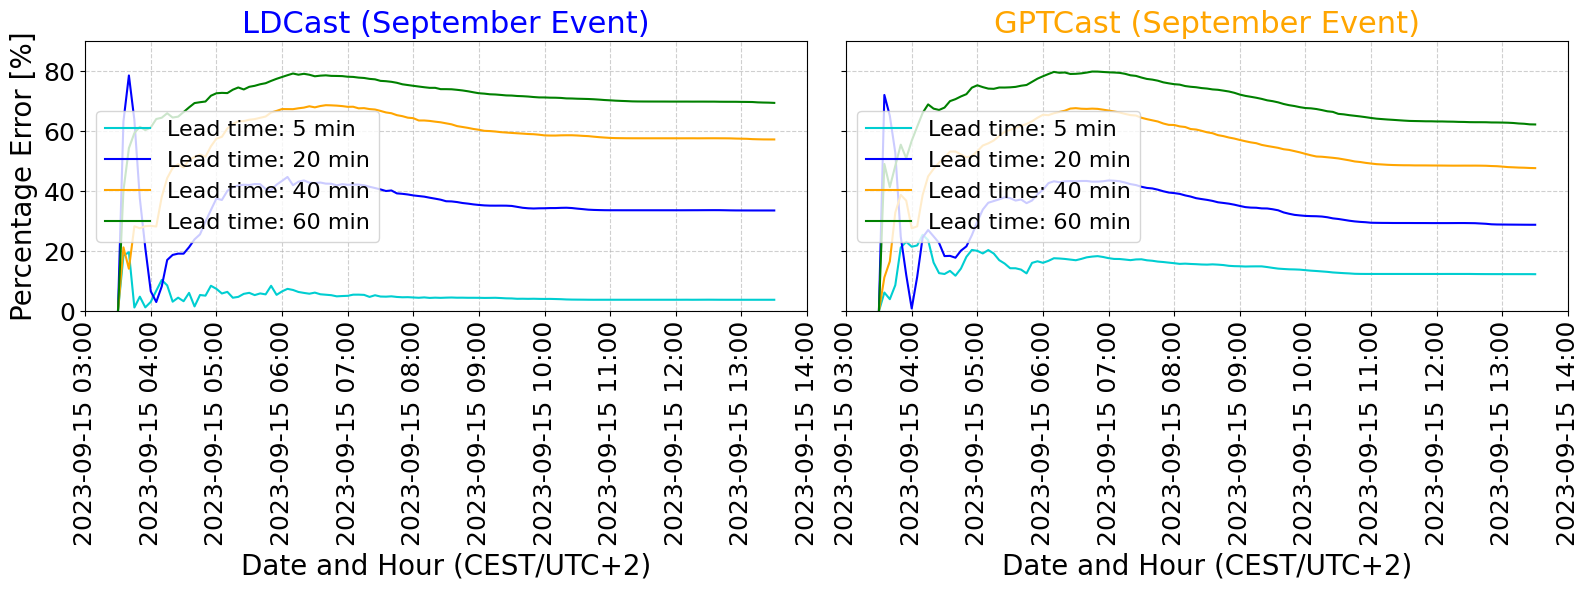

<Figure size 640x480 with 0 Axes>

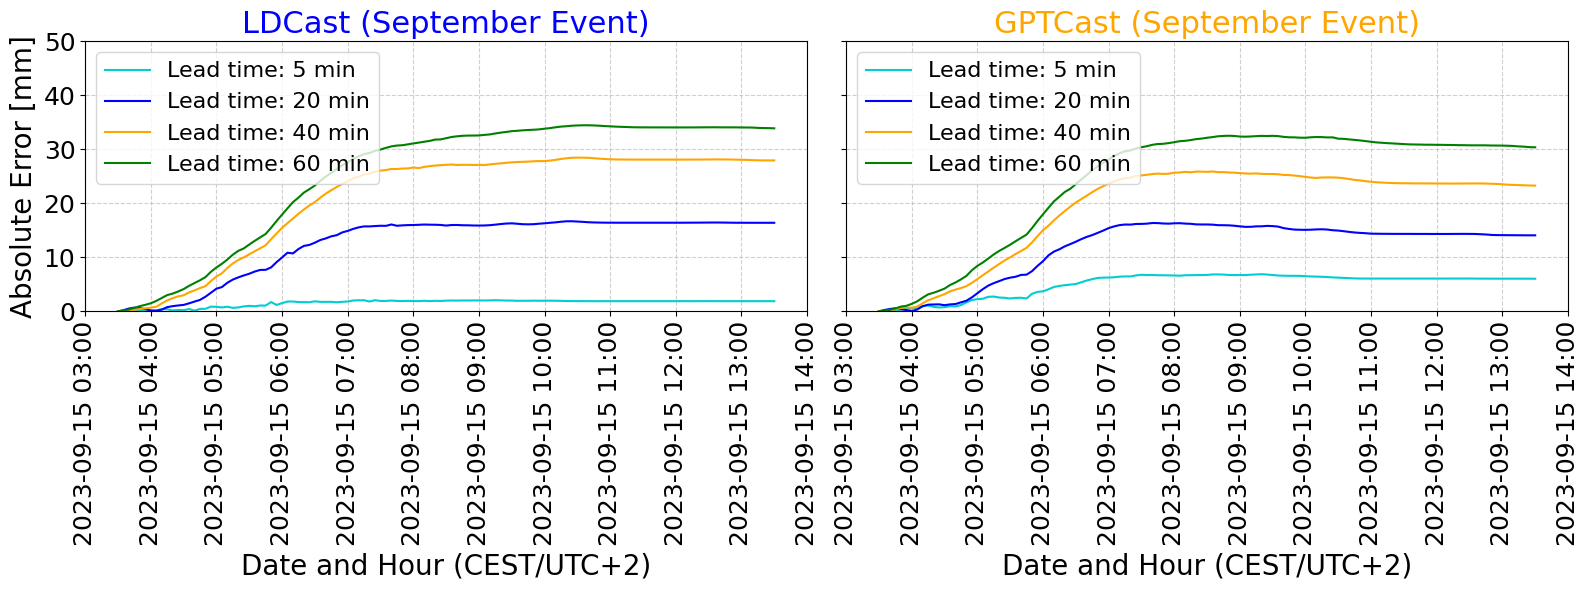

In [ ]:
#############################################################
################## CUM PREC ERROR PLOT ######################
#############################################################

def calcola_errori_per_lead_time(observed, simulated, lead_times):
    error_percentages = []
    error_absolutes = []
    
    for lead_time_index in range(len(lead_times)):
        lead_time_errors_percentage = []
        lead_time_errors_absolute = []
        
        for timestep in range(len(observed)):
            observed_value = observed[timestep]
            simulated_value = simulated[lead_time_index][timestep]  

            error_absolute = abs(simulated_value - observed_value)
            lead_time_errors_absolute.append(error_absolute)
            
            if observed_value != 0: 
                error_percentage = abs((simulated_value - observed_value) / observed_value) * 100
            else:
                error_percentage = 0  
            lead_time_errors_percentage.append(error_percentage)
        
        error_percentages.append(lead_time_errors_percentage)
        error_absolutes.append(lead_time_errors_absolute)
    
    return error_percentages, error_absolutes

ldcast_error_percentages, ldcast_error_absolutes = calcola_errori_per_lead_time(observed_rainfall, ldcast_cumulative_rainfall, lead_times)
gptcast_error_percentages, gptcast_error_absolutes = calcola_errori_per_lead_time(observed_rainfall, gptcast_cumulative_rainfall, lead_times)

def plot_error_variation_lead_times(observed_rainfall, ldcast_errors, gptcast_errors, lead_times, timestamp_iniziale, time_interval, error_type, y_limits):
    start_time = datetime.strptime(timestamp_iniziale, "%Y-%m-%dT%H:%M:%S") + timedelta(minutes=15)
    end_time = start_time + timedelta(minutes=7 * 60)  # 7 ore dopo
    time_axis = [start_time + timedelta(minutes=i * time_interval) for i in range(len(observed_rainfall))]
    
    time_axis_shifted = [t + timedelta(hours=2) for t in time_axis]
    
    selected_lead_times = [5, 20, 40, 60]
    colors = ['darkturquoise', 'blue', 'orange', 'green']  # Colori per i lead time
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)  # Disposizione orizzontale e condivisione asse y
    
    for lead_time, color in zip(selected_lead_times, colors):
        if lead_time in lead_times:
            index = lead_times.index(lead_time)
            axes[0].plot(time_axis_shifted, ldcast_errors[index], color=color, label=f'Lead time: {lead_time} min', linewidth=1.5)
    axes[0].set_title('LDCast (September Event)', fontsize=22, color='blue')
    axes[0].set_xlabel('Date and Hour (CEST/UTC+2)', fontsize=20)
    axes[0].set_ylabel(f'{error_type} Error {"[%]" if error_type == "Percentage" else "[mm]"}', fontsize=20)  # Aggiunta unità di misura
    axes[0].legend(fontsize=16)
    axes[0].grid(True, linestyle='--', alpha=0.6)
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=1))
    axes[0].tick_params(axis='y', labelsize=18)
    axes[0].tick_params(axis='x', labelsize=18, rotation=90)
    
    for lead_time, color in zip(selected_lead_times, colors):
        if lead_time in lead_times:
            index = lead_times.index(lead_time)
            axes[1].plot(time_axis_shifted, gptcast_errors[index], color=color, label=f'Lead time: {lead_time} min', linewidth=1.5)
    axes[1].set_title('GPTCast (September Event)', fontsize=22, color='orange')
    axes[1].set_xlabel('Date and Hour (CEST/UTC+2)', fontsize=20)
    axes[0].set_ylabel(f'{error_type} Error {"[%]" if error_type == "Percentage" else "[mm]"}', fontsize=20)  # Aggiunta unità di misura
    axes[1].legend(fontsize=16)
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
    axes[1].tick_params(axis='y', labelsize=18)
    axes[1].tick_params(axis='x', labelsize=18, rotation=90)
    
    axes[0].set_ylim(y_limits[0])  
    axes[1].set_ylim(y_limits[1])  
    
    plt.tight_layout()
    plt.show()

plot_error_variation_lead_times(
    observed_rainfall=observed_rainfall,
    ldcast_errors=ldcast_error_percentages,
    gptcast_errors=gptcast_error_percentages,
    lead_times=lead_times,
    timestamp_iniziale=timestamp_iniziale,
    time_interval=time_interval,
    error_type='Percentage',
    y_limits=[(0, 90), (0, 90)]  
)

plot_error_variation_lead_times(
    observed_rainfall=observed_rainfall,
    ldcast_errors=ldcast_error_absolutes,
    gptcast_errors=gptcast_error_absolutes,
    lead_times=lead_times,
    timestamp_iniziale=timestamp_iniziale,
    time_interval=time_interval,
    error_type='Absolute',
    y_limits=[(0, 50), (0, 50)] 
)

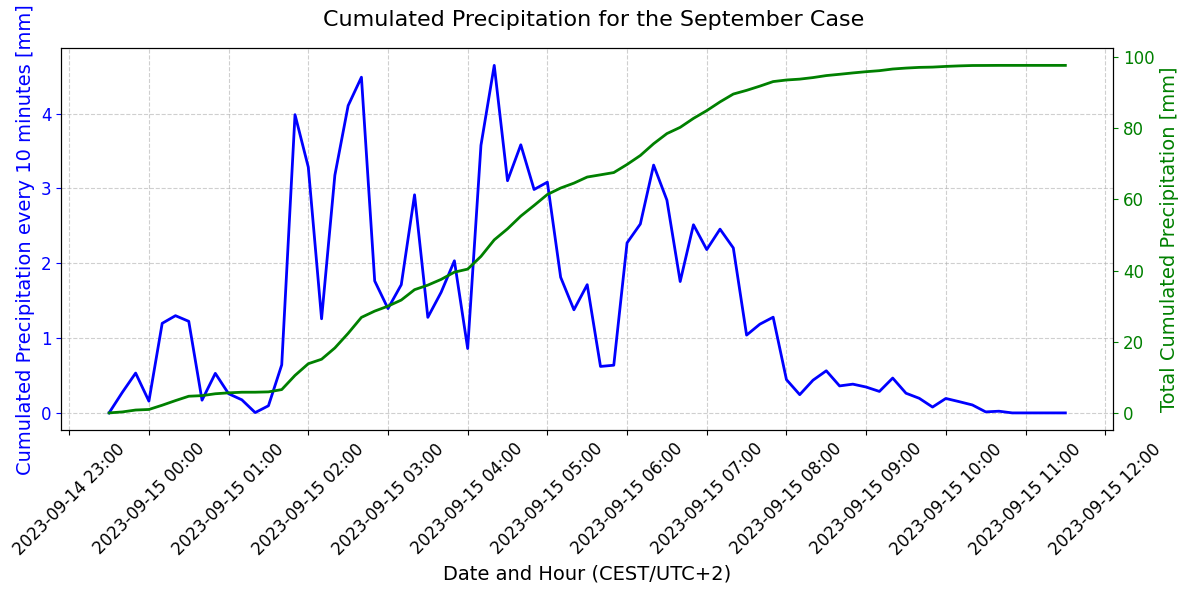

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Leggi il file Excel con le intestazioni
excel_file = "rappr_sept.xlsx"
df = pd.read_excel(excel_file)

# Converti la colonna 'date_hour' in formato datetime
df['date_hour'] = pd.to_datetime(df['date_hour'])  # Prima colonna: data e orario

df['date_hour'] = [t + timedelta(hours=1) for t in df['date_hour']]

# Estrai le colonne necessarie
cumulata_10min = df['Cumulata_10min']  # Seconda colonna: cumulate ogni 10 minuti
cumulata_totale = df['Cumulata_All']  # Terza colonna: cumulata totale

# Creazione del grafico con due scale
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primo asse (sinistro) per la cumulata ogni 10 minuti
ax1.plot(df['date_hour'], cumulata_10min, color='blue', label='Cumulated Precipitation every 10 minutes', linewidth=2)
ax1.set_xlabel('Date and Hour (CEST/UTC+2)', fontsize=14)
ax1.set_ylabel('Cumulated Precipitation every 10 minutes [mm]', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelsize=12, colors='blue')
ax1.tick_params(axis='x', labelsize=12, rotation=45)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax1.grid(True, linestyle='--', alpha=0.6)

# Secondo asse (destro) per la cumulata totale
ax2 = ax1.twinx()
ax2.plot(df['date_hour'], cumulata_totale, color='green', label='Cumulata Totale', linewidth=2)
ax2.set_ylabel('Total Cumulated Precipitation [mm]', fontsize=14, color='green')
ax2.tick_params(axis='y', labelsize=12, colors='green')

# Titolo e legenda
fig.suptitle('Cumulated Precipitation for the September Case', fontsize=16)

# Layout e visualizzazione
plt.tight_layout()
plt.savefig('cumul_sept.png', dpi=300)
plt.show()